## 1. Set SQL context and import necessary libraries

In [1]:
import findspark
findspark.init()
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
import pandas as pd

In [2]:
spark = SparkSession.builder.getOrCreate()

sc = spark.sparkContext

In [4]:
header = ['Date_Disbursement','Date_Maturity','State','DAT_BIRTH_CUST','TXT_CUST_SEX','MAR_STATUS','loan_period','loan_amount','Balance_Book','NAM_PRODUCT','Installment_amount','int_rate','Total_Amount_Arrears','number_of_installment_Arrear','Class']

df_1 = pd.read_csv('Data/salma_31-12-2017_sheet_1.csv', names = header)
df_2 = pd.read_csv('Data/salma_31-12-2017_sheet_2.csv' , names = header)
df_3 = pd.read_csv('Data/salma_31-12-2017_sheet_3.csv' , names = header)

frames = [df_1, df_2, df_3]
result = pd.concat(frames,ignore_index=True)
#df_conc_without_dup =  result.drop_duplicates(keep = False)



C:\Users\billis\Anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (6,7,8,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
result.head(4)

,Date_Disbursement,Date_Maturity,State,DAT_BIRTH_CUST,TXT_CUST_SEX,MAR_STATUS,loan_period,loan_amount,Balance_Book,NAM_PRODUCT,Installment_amount,int_rate,Total_Amount_Arrears,number_of_installment_Arrear,Class
1,10/28/2004,10/31/2009,Cairo,10/24/1953,F,Married,60,23000,0,Loan of government employees- New,536.67,8,0,0,ND
2,11/3/2004,11/30/2009,Cairo,5/15/1954,M,Married,60,14000,0,Loan of government employees- New,326.67,8,0,0,ND
3,11/3/2004,11/30/2009,Cairo,11/5/1955,M,Married,60,13500,0,Loan of government employees- New,315,8,0,0,ND
4,11/3/2004,11/30/2009,Cairo,1/20/1965,M,Married,60,13500,0,Loan of government employees- New,315,12,0,0,ND


In [6]:
result.drop(result.head(1).index, inplace=True)


In [9]:
df_undersampled = result.drop(result[result['Class'] == 'ND'].sample(frac=0.98, random_state  = 42).index)


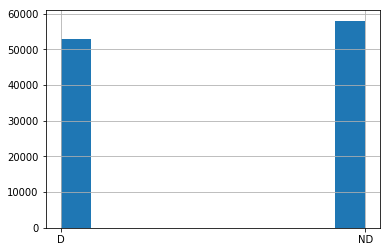

In [9]:
df_undersampled['Class'].hist()

In [10]:
df_undersampled.to_csv('Data/dataset_undersampled.csv', sep=',')

## Dataset Load

In [3]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *

def load_dataset(path):
    """
    Loads the dataset from path into a Spark Dataframe.
    
    Args
    ----------
    path : String
        Holds the path of the dataset

    Returns
    -------
    Dataframe
        Spark dataframe tha holds the records,header and the schema of the dataset.
    """
    sqlContext = SQLContext(sc)
    df = sqlContext.read.load(path, 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')
    return df

## Concatenate Dataset

In [4]:
from functools import reduce
from pyspark.sql import DataFrame

def dataframe_union(*dfs):
    """
    Concatenates the provided dataframes.
    
    Args
    ----------
    dfs : Positional argument
        Holds the dataframes

    Returns
    -------
    Dataframe
        Spark dataframe tha holds the concatenated records,header and the schema of the dataset.
    """
    return reduce(DataFrame.unionAll, dfs)  

### Replace Column Name Spaces

In [5]:
def replaceSpaces(df):  
    """
    Replace spaces with underscore bacause Spark does not handle well columns names that include spaces.
    
    Args
    ----------
    df : Dataframe
        Holds the dataframe.
    
    Returns
    -------
    Dataframe
        Spark dataframe with the encoded labels as new vector columns. 
    """
    return df.toDF(*(c.replace(' ', '_') for c in df.columns)) # Replace spaces with underscore in column names

## 2. Data pre-processing, exploration & visualization: Plotting of target variables and features

### Exploring the Data

In [61]:
# Provide descriptive statistics 
dataset_concatenated.describe('loan_amount','Balance_Book','Installment_amount','int_rate','Total_Amount_Arrears','Class').show()


+-------+------------------+------------------+------------------+------------------+--------------------+-------+
|summary|       loan_amount|      Balance_Book|Installment_amount|          int_rate|Total_Amount_Arrears|  Class|
+-------+------------------+------------------+------------------+------------------+--------------------+-------+
|  count|           2955874|           2955874|           2955874|           2955874|             2955874|2955874|
|   mean|23617.429637518377| 7125.175195427924| 773.4612615324274|18.284991308831078|   57.11183171880801|   null|
| stddev|30054.132215979094|23263.835855020414|1306.6271681687922| 8.303440735078656|  1032.5024318897235|   null|
|    min|             265.0|               0.0|             12.81|               5.0|              -407.4|      D|
|    max|         7000000.0|        5890319.31|        1249680.69|             203.0|           254536.89|     ND|
+-------+------------------+------------------+------------------+--------------

In [ ]:
dataset_concatenated

In [9]:
# Reduce the columns for examination - Only continuous variables where chosen
features_continuous = dataset_concatenated.select('loan_amount','Balance_Book','Installment_amount','int_rate','Total_Amount_Arrears')
feature_target = dataset_concatenated.select('Class')

In [16]:
# Default loans frequency 
print('Non - Default Loan percentage: ',(feature_target.filter(feature_target.Class == 'ND').count() / dataset_concatenated.count()) * 100)

# Non-Default loans frequency 
print('Default Loan percentage:',(feature_target.filter(feature_target.Class == 'D').count() / dataset_concatenated.count()) * 100)

Default Loan frequency:  98.20540388392739
Non-default Loan frequency: 1.7945961160726067


In [64]:
from pyspark.ml.feature import StringIndexer

# Convert target variable from String to Integer in order to be digested from scatter_plot method below
indexer = StringIndexer(inputCol="Class", outputCol="labelIndx")
fetureTarget_indexed = indexer.fit(feature_target).transform(feature_target)
fetureTarget_indexed.select('labelIndx').distinct().show() # Print unique values


+---------+
|labelIndx|
+---------+
|      0.0|
|      1.0|
+---------+



In [65]:
# Convert from PySpark dataframe to Pandas dataframe for visualization purposes.
pdf_pandas_features_continuous = features_continuous.toPandas()
pdf_pandas_features_target = fetureTarget_indexed.toPandas()

In [68]:
# Dataset sampling.
"""
Randomness integrated in the 'sample' method ensures the deversity of the samples drawn and
reflects the variation of the original dataset. 
"""
pdf_pandas_continuous_features_sample = pdf_pandas_features_continuous.sample(frac=0.2, replace=False)
pdf_pandas_target_feature_sample = pdf_pandas_features_target.sample(frac=0.2, replace=False)

### Visualization : Distribution scatterplots

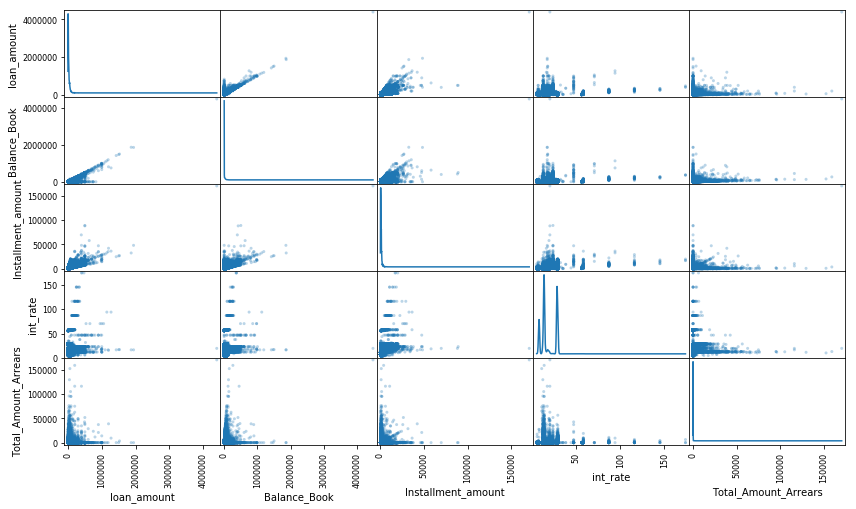

In [70]:
from IPython.display import display # Allows the use of display() for DataFrames
import pandas as pd
# Pretty display for notebooks
%matplotlib inline

# Features plotting
pd.plotting.scatter_matrix(pdf_pandas_continuous_features_sample, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

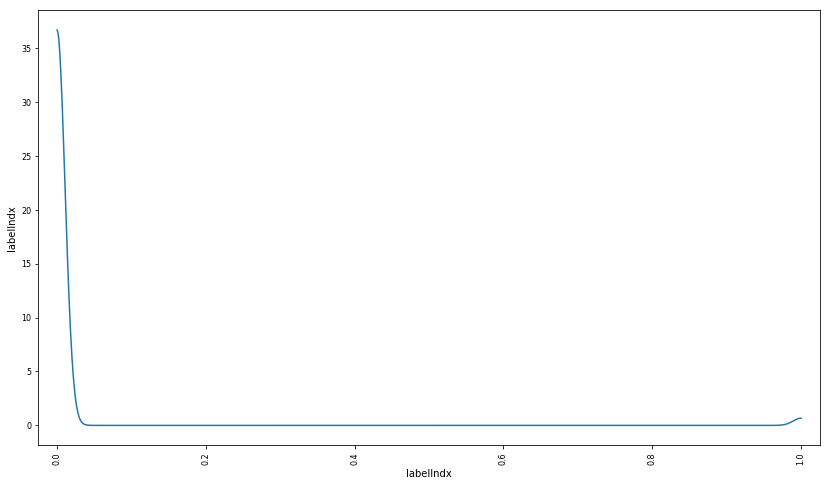

In [15]:
# Target variable visualization
pd.plotting.scatter_matrix(pdf_pandas_target_feature_sample, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

## Pre-processing

### Feature Standarization

In [6]:
from pyspark.sql.functions import stddev, mean, col


def standarization(cols, df):
    """
    Calculates the mean and standard deviation of the imported columns and then standarizes the columns 
    
    Args
    ----------
    cols : List
        Holds the column names.
    
    df : Dataframe
        Holds the dataframe.
        
    Returns
    -------
    Dataframe
        Spark dataframe with standarized columns. 
    """
    for colName in cols:
        col_mean, col_stddev =  df.select(mean(df[colName]), stddev(df[colName])).first()
        df = df.withColumn(colName, (df[colName] - col_mean) / col_stddev)

    return df

In [7]:
def normalization(cols, df):
    """
    Calculates the mean and standard deviation of the imported columns and then standarizes the columns 
    
    Args
    ----------
    cols : List
        Holds the column names.
    
    df : Dataframe
        Holds the dataframe.
        
    Returns
    -------
    Dataframe
        Spark dataframe with standarized columns. 
    """
    for colName in cols:
        maxVal = df.agg({colName: "max"}).collect()[0][0]
        minVal = df.agg({colName: "min"}).collect()[0][0]
        df = df.withColumn(colName, (df[colName] - minVal) / (maxVal - minVal))
    return df

In [8]:
from functools import reduce
from pyspark.sql import DataFrame
def redundantColumnsDrop (cols,df):
    """
    Removes the columns left from StrtingToIndex and OneHotEncoding conversions.
    
    Args
    ----------
    *cols : Positional argument
        Holds the redundant column names.
        
    Returns
    -------
    Dataframe
        Spark dataframe without the unnecessary columns. 
    """
    return reduce(DataFrame.drop, cols, df)

### Convert date columns 

In [9]:
from datetime import datetime
from pyspark.sql.functions import col, udf
from pyspark.sql.functions import to_timestamp

def columnsConvert(df): 
    """
    Convert the date columns from StringType to DateType() using user defined function.

    Args
    ----------
    df : Dataframe
        Holds the dataframe.

    Returns
    -------
    Dataframe
        Spark dataframe with all the columns that include dates converted from StringType() to DateTyoe().
    """
    dateType_func = udf (lambda x: datetime.strptime(x, '%m/%d/%Y'), DateType()) # 

    df = (df.withColumn('Date_Disbursement', dateType_func(col('Date_Disbursement')))
               .withColumn('Date_Maturity', dateType_func(col('Date_Maturity')))
               .withColumn('DAT_BIRTH_CUST', dateType_func(col('DAT_BIRTH_CUST'))))
    
    return df

### Calculate Age

In [10]:
from dateutil.relativedelta import *
from datetime import date

def ageCalculate(date_year,date_monh,date_day):
    """
    Calculates the age of the customer based on the current and birth date. UDF is going to be used to wrap this function.
    
    Args
    ----------
    date_year : Integer
        Holds the year born.
    
    date_monh : Integer
        Holds the month born.
        
    date_day : Integer
        Holds the day born.
    
    Returns
    -------
    Integer
        Returns the the calculated age of the customer. 
    """
    today = date.today()  
    dob = date(date_year,date_monh, date_day)
    age = relativedelta(today, dob)
    return age.years

In [38]:
from datetime import date
from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql.types import IntegerType
from datetime import date, timedelta

# Get the current date
today = date.today() 

# Define the 'ageCalcule' function.
ageCalculation_func = udf(ageCalculate, IntegerType()) 

# Calculate age based on the column that holds the DoB.
df_final = (df_final.withColumn('DAT_BIRTH_CUST', ageCalculation_func(year(col("DAT_BIRTH_CUST")),month(col("DAT_BIRTH_CUST")),dayofmonth(col("DAT_BIRTH_CUST")))))


### Feature Engineering 

#### Year feture extraction

In [11]:
from pyspark.sql.functions import year, month, dayofmonth,unix_timestamp

def featureExtractionYear(df): 
    """
    Engineers new features from the date columns. It extracts Years and saves them into different columns.

    Args
    ----------
    df : Dataframe
        Holds the dataframe.

    Returns
    -------
    Dataframe
        Returns the dataframe with the extracted features and new columns. 
    """

    df = (df.withColumn('disbursement_year', year(col('Date_Disbursement')))
                .withColumn('maturity_year', year(col('Date_Maturity'))))

    return df


In [12]:
from pyspark.sql.functions import year, month, dayofmonth,unix_timestamp

def featureExtractionDayMonth(df): 
    """
    Engineers new features from the date columns. It extracts Years and saves them into different columns.

    Args
    ----------
    df : Dataframe
        Holds the dataframe.

    Returns
    -------
    Dataframe
        Returns the dataframe with the extracted features and new columns. 
    """

    df = (df.withColumn('disbursement_month', month(col('Date_Disbursement')))
                .withColumn('maturity_month', month(col('Date_Maturity')))
                 .withColumn('maturity_day', dayofmonth(col('Date_Maturity')))
                 .withColumn('disbursement_day', dayofmonth(col('Date_Disbursement'))))

    return df

### Date Feature Transformation

In [13]:
import math

def cyclicTransofrmation(df):
    """
    Transforms the extracted features, month and dayofmonth, using fourier transformations. 
    Dates are considered cyclical variables, hence the similarity between e.g. month 12 and 1 is very big, 
    however without the tranformation the distance of these two months for example is very high which is unwanted result. 
    
    Args
    ----------
    df : Dataframe
        Holds the dataframe.
    
    Returns
    -------
    Dataframe
        Returns dataframe including sin and cos tranformations of months and dayofmonh, as newely engineered features of the dataset. 
    """
    
    func_month_sin_tranformation = udf(lambda x:math.sin((x - 1)*(2.*math.pi/12)), returnType=FloatType()) # Sin tranformation of the year
    func_month_cos_tranformation = udf(lambda x:math.cos((x - 1)*(2.*math.pi/12)), returnType=FloatType()) # Cos transformation of the year

    func_days_of_month_sin_transformation = udf(lambda x : math.sin((2*math.pi)/30*x), returnType=FloatType()) # Sin transformation of the month
    func_days_of_month_cos_transformation = udf(lambda x : math.cos((2*math.pi)/30*x), returnType=FloatType()) # Cos transformation of the month

    # Feature engineering
    df = (df.withColumn('Date_Disbursement_sin_month',  func_month_sin_tranformation(month(col('Date_Disbursement'))))
                .withColumn('Date_Disbursement_cos_month',func_month_cos_tranformation(month(col('Date_Disbursement'))))
                .withColumn('maturity_sin_month',func_month_sin_tranformation(month(col('Date_Maturity'))))
                .withColumn('maturity_cos_month',func_month_cos_tranformation(month(col('Date_Maturity'))))
                .withColumn('Date_Disbursement_sin_dayofmonth', func_days_of_month_sin_transformation(dayofmonth(col('Date_Disbursement'))))
                .withColumn('Date_Disbursement_cos_dayofmonth', func_days_of_month_cos_transformation(dayofmonth(col('Date_Disbursement'))))
                .withColumn('maturity_sin_dayofmonth',func_days_of_month_sin_transformation(dayofmonth(col('Date_Maturity'))))
                .withColumn('maturity_cos_dayofmonth',func_days_of_month_cos_transformation(dayofmonth(col('Date_Maturity'))))
               )
    return df      

## Categorical Encoding 

### Indexing, Assembling & Categorical encoding 

#### Catecorical variables indexing/encoding/assembling steps

In [14]:
### Indexing and One-Hot Encoding
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

def stagesPipeline(categoricalColumns, numericCols):
    """
    Creates a pipeline of indexers and categorical encoders converts the string labels of the chosen columns into numerical values (indexes).
    The creates encoders in order to covnert indexes to categorical vectors. Finally, feature assemblers are created and return in the form of a list.
    
    Args
    ----------
    colNames : List
        Holds the column names.
        
    Returns
    -------
    Stages : List
        A list with the indexers, encoders and assembler steps. 
    """
    stages = [] # stages in our Pipeline
    for categoricalCol in categoricalColumns:
      # Category Indexing with StringIndexer
      stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+"Index",handleInvalid = 'skip')
      # Use OneHotEncoder to convert categorical variables into binary SparseVectors
      encoder = OneHotEncoder(inputCol=categoricalCol+"Index", outputCol=categoricalCol+"classVec")
      # Add stages.  These are not run here, but will run all at once later on.
      stages += [stringIndexer, encoder]
        
    # Creates an index of the target variable.
    label_stringIdx = StringIndexer(inputCol = "Class", outputCol = "label")
    stages += [label_stringIdx]
    
    # Transform all features into a vector using VectorAssembler
    assemblerInputs =list(map(lambda c: c + "classVec", categoricalColumns)) + numericCols
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
    stages += [assembler]
    
    return stages

#### Create pipeline

In [15]:
from pyspark.ml import Pipeline
def pipelineFunc(stages, df):      
    """
    Run the feature transformations.
    
    Args
    ----------
    stages : List
        Holds the stages for the pipeline.
        
    Returns
    -------
    dataset : Dataframe
        Tranformed dataset. 
    """

    pipeline = Pipeline(stages=stages)
    pipelineModel = pipeline.fit(df)#  - fit() computes feature statistics as needed.
    dataset = pipelineModel.transform(df)# - transform() actually transforms the features.
    display(dataset)
    return dataset

In [16]:
from datetime import date
from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql.types import IntegerType
from datetime import date, timedelta

def dataLoadPreprocess(Normalization, Standarization, df):
    # Load individual datasets    
    cols = ['loan_period','loan_amount','Balance_Book','Installment_amount','int_rate','Total_Amount_Arrears']
    
    # Convert StringType() columns that contain dates to DateType()
    df = columnsConvert(df)
    
    # Get the current date
    today = date.today() 

    # Define the 'ageCalcule' function.
    ageCalculation_func = udf(ageCalculate, IntegerType()) 

    # Calculate age based on the column that holds the DoB.
    df = (df.withColumn('DAT_BIRTH_CUST', ageCalculation_func(year(col("DAT_BIRTH_CUST")),month(col("DAT_BIRTH_CUST")),dayofmonth(col("DAT_BIRTH_CUST")))))

    df = featureExtractionYear(df)

    df = featureExtractionDayMonth(df)
    
    if Normalization : 
        print('Normalized')
        df = normalization(cols, df) # Normalize numerical columns
    else:
        df = standarization(cols, df) # Standarize numerical columns
    

    

    #df = cyclicTransofrmation(df)

    categoricalColumns = ["State","TXT_CUST_SEX", "MAR_STATUS","NAM_PRODUCT"]
    #numericColumns = ['loan_period','loan_amount','Balance_Book','Installment_amount','int_rate','Total_Amount_Arrears','number_of_installment_Arrear','disbursement_year','maturity_year','Date_Disbursement_sin_month','Date_Disbursement_cos_month','maturity_sin_month','maturity_cos_month','Date_Disbursement_sin_dayofmonth','Date_Disbursement_cos_dayofmonth','maturity_sin_dayofmonth','maturity_cos_dayofmonth']
    numericColumns = ['loan_period','loan_amount','Balance_Book','Installment_amount','int_rate','Total_Amount_Arrears','number_of_installment_Arrear','disbursement_year','maturity_year','disbursement_month','maturity_month','disbursement_day','maturity_day']

    stages = stagesPipeline(categoricalColumns,numericColumns)

    dataset = pipelineFunc(stages, df)
    
    return dataset

#### Dataset Split

In [17]:
def train_test_split(df):
    """
    Spits the dataset into training and testing sub-datasets using randomSplit() function.
    
    Args
    ----------
    df : Dataframe
        Holds the dataframe.
        
    Returns
    -------
    (train, test) : Dataframe
        Splitted dataset. 
    """
    #dataset_reduced = dataset.select('features','label')
    #(train, test) = df.randomSplit([0.7, 0.3], seed = 100)
    #t1 = train.sample(False, 0.001, 42)
    #t2 = test.sample(False, 0.001, 43)
    return df.select('features','label').randomSplit([0.7, 0.3],seed = 100)

In [18]:
from pyspark.ml.classification import MultilayerPerceptronClassifier, LinearSVC, DecisionTreeClassifier,LogisticRegression,RandomForestClassifier,GBTClassifier
from pyspark.ml.classification import RandomForestClassifier 

def estimators():
    """
    Defines estimators.
    
    Args
    ----------
    None
        
    Returns
    -------
    List of classifiers
     
    """
    LR  = LogisticRegression(featuresCol='features', labelCol='label')
    SVM = LinearSVC(featuresCol='features', labelCol='label')
    GT  = GBTClassifier(featuresCol="features", labelCol="label",seed=42)
    DT  = DecisionTreeClassifier(featuresCol='features', labelCol='label', impurity = 'gini',seed = 42)
    NN  = MultilayerPerceptronClassifier(featuresCol='features', labelCol='label', layers = [97, 65, 32, 2], seed = 42)
    RF = RandomForestClassifier(labelCol='label', featuresCol='features')
    return [LR,SVM,GT,DT,NN,RF]

In [19]:
from pyspark.ml.tuning import ParamGridBuilder,  CrossValidator

def hyperParameters(estimators):
    """
    Constructs the parameters for the optimization process.
    
    Args
    ----------
    estimators : List
        Holds the estimators.
        
    Returns
    -------
    List of grid parameters. 
    """
    paramGridLR = (ParamGridBuilder()
                 .addGrid(estimators[0].regParam, [0.01, 0.5, 2.0])
                 .addGrid(estimators[0].elasticNetParam, [0.0, 0.5, 1.0])
                 .addGrid(estimators[0].maxIter, [10,30,50,70,100,150])
                 .build())

    paramGridSVM = (ParamGridBuilder()
                 .addGrid(estimators[1].maxIter, [1, 5, 10, 50,100,150])
                 .addGrid(estimators[1].tol, [1e-02, 1e-05,1e-06, 1e-08])
                 .addGrid(estimators[1].fitIntercept, [True, False])
                 .addGrid(estimators[1].standardization, [False])
                 .addGrid(estimators[1].threshold, [0.0, 0.2, 0.5, 0.7, 0.8])
                 .addGrid(estimators[1].aggregationDepth, [2,3,4,5,6,8,10,12])
                 .build())

    paramGridGT = (ParamGridBuilder()
                 .addGrid(estimators[2].maxIter, [1, 5, 10, 50,100,150])
                 .addGrid(estimators[2].maxDepth, [1,2,6,8,10])
                 
                 .addGrid(estimators[2].maxBins, [20,30,40])
                 .build())

    paramGridDT = (ParamGridBuilder()
                 .addGrid(estimators[3].maxDepth, [1,2,6,8])
                 .addGrid(estimators[3].maxBins, [20,30,40])
                 .build())

    paramGridNN = (ParamGridBuilder()
                 .addGrid(estimators[4].maxIter, [10,30,50,70,100])
                 .addGrid(estimators[4].tol, [1e-02,1e-04,1e-06])
                 .addGrid(estimators[4].blockSize, [32,64,128,256]) 
                 .addGrid(estimators[4].solver, ['l-bfgs','gd'])  
                 .addGrid(estimators[4].stepSize, [0.02, 0.03,0.05])  
                 .build())

    paramGridRF = (ParamGridBuilder()
                 .addGrid(estimators[5].maxDepth, [1,2,6,10])
                 .addGrid(estimators[5].maxBins, [16,32,64,128])
                 .addGrid(estimators[5].impurity, ['gini','entropy'])
                 .addGrid(estimators[5].featureSubsetStrategy, ['all', 'sqrt', 'log2'])
                 .addGrid(estimators[5].numTrees, [10,20,50,100,150])
                 .build())
    
    return [paramGridLR,paramGridSVM,paramGridGT,paramGridDT,paramGridNN,paramGridRF]

In [30]:
row = dataset_scaled.select('features').first()
len(row.features) # Cound the number of input features for the Neural Network.

In [20]:
from sklearn.metrics import roc_curve, auc
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from matplotlib import pyplot as plt

def vizualization(transformed, name):
    """
    Visualizes performance.
    
    Args
    ----------
    transformed : Dataframe
        Normalized or Standarized dataset.
    
    name : Object 
        Name of the estimator.
        
    """
    results = transformed.select(['probability', 'label'])
 
    ## prepare score-label set
    results_collect = results.collect()
    results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
    scoreAndLabels = sc.parallelize(results_list)

    metrics = metric(scoreAndLabels)
    print("The ROC score is (", name,"): ", metrics.areaUnderROC)
    
    
 
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_test = [i[1] for i in results_list]
    y_score = [i[0] for i in results_list]

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    %matplotlib inline
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

### Model Training, Selection and Evaluation

In [21]:
from time import time
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator

def modelTraining(classifiers, parameters, evaluator, train, test):
    """
    Initiates training process.
    
    Args
    ----------
    classifiers : List
        Holds the estimators.
    
    parameters : List
        Holds the parameter grids.
        
    evaluator : Object
        Holds the type of object that evaluates the the estimator.
    
    train : dataframe
        Holds the train set.
    
    test : dataframe
        Holds the test set.
        
    Returns
    -------
    List of grid parameters. 
    """
    
    log_cols=["Classifier", "Area Under R0C - Accuracy", 'Area Under PR',"Test Error ROC","Test Error PRC","CrossVal Performance","Model"]
    log = pd.DataFrame(columns=log_cols)
    
    for clf, params in zip(classifiers, parameters):
        
        name = clf.__class__.__name__ # Get classifier's name
        cv = CrossValidator(estimator=clf, estimatorParamMaps=params, evaluator=evaluator, numFolds=10) # Cros-validation
        t0 = time()
        cvModel = cv.fit(train) # Training.
        tt = time() - t0
        
        # Model evaluation
        predictions = cvModel.transform(test) 
        auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
        aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
        
        # Performance Visualization
        vizualization(predictions, name)
        
        # Avergage performance
        avgMetrics = cvModel.avgMetrics
        
    
        # Create (prediction, label) pairs
        predictionAndLabel = predictions.select("prediction", "label").rdd

        # Generate confusion matrix
        metrics = MulticlassMetrics(predictionAndLabel)
        print (metrics.confusionMatrix())
        
        print("="*30)
        print(name)     
        print('****Results****')
        print("Training Time {:.4%}".format(tt))
        print("ROC: {:.4%}".format(auroc))
        print("PRC: {:.4%}".format(aupr))
        print("Test Error ROC= %g " % (1.0 - auroc))
        print("Test Error PRC= %g " % (1.0 - aupr))
        print("="*30)
        
        # Save the data to a log
        log_entry = pd.DataFrame([[name, auroc*100,aupr*100 ,1.0 - auroc,1.0 - aupr, avgMetrics,cvModel.bestModel]], columns=log_cols)
        try:
            cvModel.save('models' + cvModel.bestModel)
        except:
            print('Model not saved')
        
            
    log = log.append(log_entry)
    return log

In [22]:
#dataset = load_dataset('Data/dataset_undersampled.csv')
df_first = load_dataset('Data/salma_31-12-2017_sheet_1.csv') # First sheet
df_second = load_dataset('Data/salma_31-12-2017_sheet_2.csv') # Second sheet
df_third = load_dataset('Data/salma_31-12-2017_sheet_3.csv') # Third sheet

dataset.printSchema()

# Concatenate datasets
dataset_concatenated = dataframe_union(*[df_first, df_second, df_third]) # Concatenate all the loaded dataframes.

# Replace space in the names 
dataset = replaceSpaces(dataset_concatenated)

# Strip white spaces
dataset = redundantColumnsDrop(['_c0'],dataset)
#dataset_concatenated.printSchema()

In [29]:
dataset.printSchema()

root
 |-- Date_Disbursement: string (nullable = true)
 |-- Date_Maturity: string (nullable = true)
 |-- State: string (nullable = true)
 |-- DAT_BIRTH_CUST: string (nullable = true)
 |-- TXT_CUST_SEX: string (nullable = true)
 |-- MAR_STATUS: string (nullable = true)
 |-- loan_period: integer (nullable = true)
 |-- loan_amount: double (nullable = true)
 |-- Balance_Book: double (nullable = true)
 |-- NAM_PRODUCT: string (nullable = true)
 |-- Installment_amount: double (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- Total_Amount_Arrears: double (nullable = true)
 |-- number_of_installment_Arrear: integer (nullable = true)
 |-- Class: string (nullable = true)



In [23]:
dataset_scaled = dataLoadPreprocess(True, False,dataset)
(train,test) = train_test_split(dataset_scaled)

Normalized


DataFrame[Date_Disbursement: date, Date_Maturity: date, State: string, DAT_BIRTH_CUST: int, TXT_CUST_SEX: string, MAR_STATUS: string, loan_period: double, loan_amount: double, Balance_Book: double, NAM_PRODUCT: string, Installment_amount: double, int_rate: double, Total_Amount_Arrears: double, number_of_installment_Arrear: int, Class: string, disbursement_year: int, maturity_year: int, disbursement_month: int, maturity_month: int, maturity_day: int, disbursement_day: int, StateIndex: double, StateclassVec: vector, TXT_CUST_SEXIndex: double, TXT_CUST_SEXclassVec: vector, MAR_STATUSIndex: double, MAR_STATUSclassVec: vector, NAM_PRODUCTIndex: double, NAM_PRODUCTclassVec: vector, label: double, features: vector]

The ROC score is ( LogisticRegression ):  0.9795303957828645


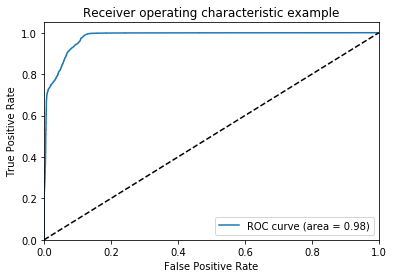

LogisticRegression
****Results****
Training Time 
ROC: 97.9530%
PRC: 98.1347%
Test Error ROC= 0.0204696 
Test Error PRC= 0.0186532 
Model not saved


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator

results_log = modelTraining(classifiers ,hyper_parameters, evaluator, train, test)